c:\Users\rahat\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:11:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\rahat\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:11:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\rahat\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:11:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
2025/07/13 06:11:14 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: Solving single objective optimization problem.
c:\Users\rahat\AppData\Loc


✅ Selected Features: ['WBC Count', 'Platelet Count']
Number of Features Selected: 2

✅ Best Hyperparameters Found by PSO:
n_estimators: 50
max_depth: 10
learning_rate: 0.18857364028695361
subsample: 0.9628820703509359
colsample_bytree: 0.6

✅ Final CV Accuracy: 0.97755698005698

✅ Test Accuracy: 0.9867109634551495

✅ Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98        97
           1       0.99      1.00      0.99       204

    accuracy                           0.99       301
   macro avg       0.99      0.98      0.98       301
weighted avg       0.99      0.99      0.99       301


✅ Confusion Matrix:
 [[ 94   3]
 [  1 203]]


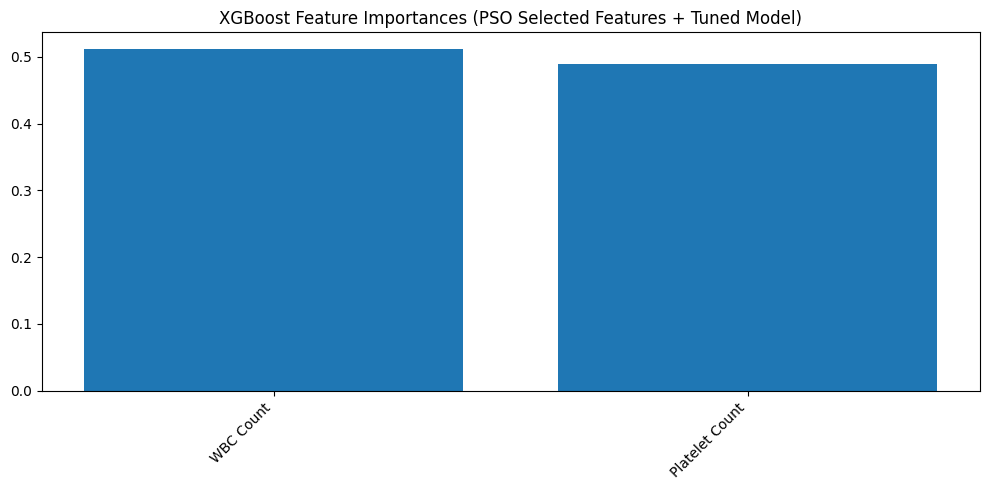

In [1]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from mealpy.swarm_based.PSO import OriginalPSO
from mealpy.utils.problem import Problem
import matplotlib.pyplot as plt

# Set random seed
np.random.seed(42)

# Cell 2: Load and Preprocess Data
data = pd.read_csv("../Datasets/dengue.csv")
data['Sex'] = data['Sex'].map({'Male': 0, 'Female': 1, 'Child': 2})
data = data.fillna(data.mean(numeric_only=True))
X = data.drop('target', axis=1)
y = data['target'].astype(int)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Cell 3: Define Fitness Function for Feature Selection + Hyperparameter Tuning
def fitness(solution):
    binary_mask = (solution[:X_train.shape[1]] > 0.5).astype(int)
    if np.sum(binary_mask) == 0:
        return 1.0

    selected_X = X_train[:, binary_mask == 1]

    n_estimators = int(solution[-5])
    max_depth = int(solution[-4]) if solution[-4] > 0 else None
    learning_rate = float(solution[-3])
    subsample = float(solution[-2])
    colsample_bytree = float(solution[-1])

    model = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1
    )

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = cross_val_score(model, selected_X, y_train, cv=cv, scoring='accuracy')
    penalty = np.sum(binary_mask) / len(binary_mask)
    return 1 - scores.mean() + 0.01 * penalty

# Cell 4: Setup PSO for Feature Selection + Hyperparameter Optimization
feature_dim = X_train.shape[1]
lb = [0] * feature_dim + [50, 3, 0.01, 0.6, 0.6]  # [binary mask] + [n_estimators, max_depth, learning_rate, subsample, colsample_bytree]
ub = [1] * feature_dim + [150, 10, 0.3, 1.0, 1.0]

problem = Problem(
    fit_func=fitness,
    lb=lb,
    ub=ub,
    minmax="min",
    verbose=True
)

pso = OriginalPSO(
    epoch=30,
    pop_size=10,
    c1=2.0,
    c2=2.0,
    w_min=0.4,
    w_max=0.9
)

best_position, best_fitness = pso.solve(problem)

# Cell 5: Extract and Print Results
binary_mask = (np.array(best_position[:feature_dim]) > 0.5).astype(int)
selected_indices = np.where(binary_mask == 1)[0]
selected_feature_names = X.columns[selected_indices]

n_estimators = int(best_position[-5])
max_depth = int(best_position[-4]) if best_position[-4] > 0 else None
learning_rate = float(best_position[-3])
subsample = float(best_position[-2])
colsample_bytree = float(best_position[-1])

print("\n✅ Selected Features:", list(selected_feature_names))
print("Number of Features Selected:", len(selected_feature_names))
print("\n✅ Best Hyperparameters Found by PSO:")
print(f"n_estimators: {n_estimators}")
print(f"max_depth: {max_depth}")
print(f"learning_rate: {learning_rate}")
print(f"subsample: {subsample}")
print(f"colsample_bytree: {colsample_bytree}")

print("\n✅ Final CV Accuracy:", 1 - best_fitness)

# Cell 6: Train Final Model and Evaluate
X_train_selected = X_train[:, binary_mask == 1]
X_test_selected = X_test[:, binary_mask == 1]

best_model = XGBClassifier(
    n_estimators=n_estimators,
    max_depth=max_depth,
    learning_rate=learning_rate,
    subsample=subsample,
    colsample_bytree=colsample_bytree,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

best_model.fit(X_train_selected, y_train)
y_pred = best_model.predict(X_test_selected)

print('\n✅ Test Accuracy:', accuracy_score(y_test, y_pred))
print('\n✅ Classification Report:\n', classification_report(y_test, y_pred))
print('\n✅ Confusion Matrix:\n', confusion_matrix(y_test, y_pred))

# Cell 7: Plot Feature Importance
importances = best_model.feature_importances_
plt.figure(figsize=(10, 5))
plt.bar(selected_feature_names, importances)
plt.xticks(rotation=45, ha='right')
plt.title("XGBoost Feature Importances (PSO Selected Features + Tuned Model)")
plt.tight_layout()
plt.show()
